# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
!pip install phik

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
import phik

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

# Константы
RANDOM_STATE = 42


plt.rcParams["figure.figsize"] = (14, 7)


In [2]:
# загрузка данных

try:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')
except:
    df = pd.read_csv('/datasets/autos.csv')


In [3]:
# изучим данные

display(df.info())
print('_' * 230)
display(df.head())
print('_' * 230)
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

______________________________________________________________________________________________________________________________________________________________________________________________________________________________________


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


______________________________________________________________________________________________________________________________________________________________________________________________________________________________________


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [4]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

**Вывод:**

- столбец `NumberOfPictures` имеет везде нули (можно его удалить)
- столбцы `PostalCode`, `DateCrawled`, `DateCreated`, `RegistrationMonth` и `LastSeen` не несут информативности их тоже можно удалить
- необходимо привести название столбцов к правильному типу написание 
- имеются пропуски `VehicleType`, `Gearbox`, `Model`, `FuelType`, `71154`
- присутствуют явные аномалии в годах регистрации, мощности и цене (нулевые или слишком высокие значения) — нужно фильтровать или исправлять

In [5]:
# удалим столбцы `NumberOfPictures`, `PostalCode`, `DateCrawled`, `DateCreated`, `RegistrationMonth` и `LastSeen`

df.drop(
    [
        'NumberOfPictures', 'PostalCode', 'DateCrawled', 
        'DateCreated', 'LastSeen', 'RegistrationMonth'
    ], 
    axis=1, inplace=True
)

# проверка

df.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'Repaired'],
      dtype='object')

In [6]:
#переведем наименование стлбцов в коректную форму 

df.columns = [re.sub(r'(?<=[a-z])(?=[A-Z])', '_', col).lower() for col in df.columns]

# роверка

df.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')

In [7]:
# заменим пропуски на unknown 
# пропуски встречаются только в категориальных признаках

df.fillna("unknown", inplace=True)

# проверка

df.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

In [8]:
# проверим на количество дубликатов 

df.duplicated().sum()

45040

In [9]:
# удалим дубликаты, чтобы избежать искажений в модели и снизижения риска переобучения

df.drop_duplicates(inplace=True)

# проверка

df.duplicated().sum()

0

**Вывод:** 

**Удалены неинформативные столбцы** `NumberOfPictures`, `PostalCode`, `DateCrawled`, `DateCreated` и `LastSeen` 

**Наименование столбцов приведены в коректную форму** 

**Пропуски заменены на unknown**

**Удалены дубликаты, чтобы избежать искажений в модели и снизижения риса переобучения**

**В столбце `registration_year` есть "необычные" года как:** 1111, 9999, 3200 и т.д.

**В столбце `power` также имеются необычные значения для л.с.:** 0, 1240, 1001 и т.д.


## Исследовательский анализ данных

In [10]:
#функция для построения гистограмм и диаграмм размаха для количественных признаков

def plot_box_and_hist(df, column, bins=10):
    
    fig, axes = plt.subplots(1, 2)  
    
    #диаграмма размаха
    
    axes[0].boxplot(df[column], patch_artist=True, boxprops=dict(facecolor='lightblue', color='black'))
    axes[0].set_title(f'Диаграмма размаха для {column}', fontsize=14)
    axes[0].set_ylabel(column, fontsize=12)
    axes[0].grid(True)
    
    #гистограмма
    
    axes[1].hist(df[column], bins=bins, color='skyblue', edgecolor='black')
    axes[1].set_title(f'Гистограмма для {column}', fontsize=14)
    axes[1].set_xlabel(column, fontsize=12)
    axes[1].set_ylabel('Частота', fontsize=12)
    axes[1].grid(True)
    

    plt.tight_layout()
    plt.show()
               
        
#функция для построения столбчатых диаграмм для категориальных признаков

def plot_categorical_bars(df, columns):
    for column in columns:
        df[column].value_counts().plot(kind='bar', color='darkgreen', edgecolor='black')
        plt.title(f'Распределение {column}', fontsize=14)
        plt.xlabel(column, fontsize=12)
        plt.ylabel('Частота', fontsize=12)
        plt.grid(True)
        plt.xticks(rotation=0)
        plt.show()

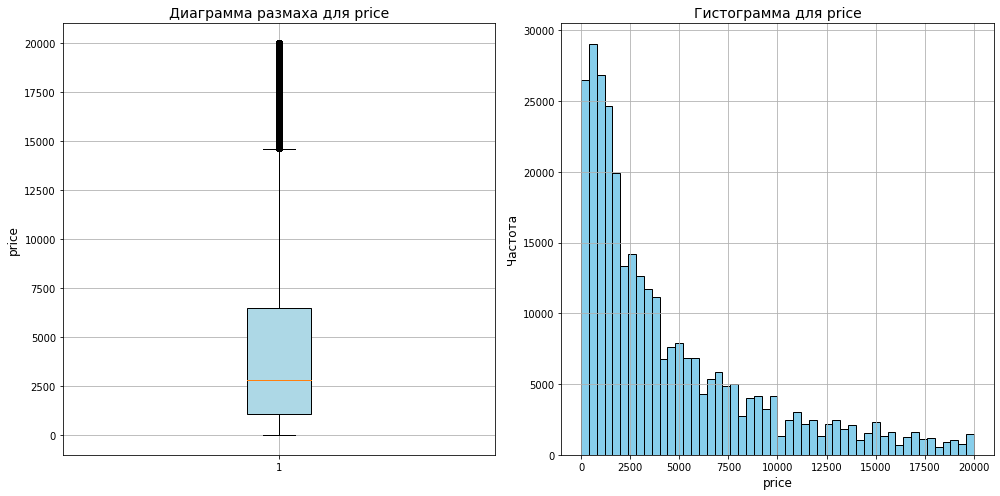

count    309329.000000
mean       4486.937196
std        4564.852796
min           0.000000
25%        1100.000000
50%        2800.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64

In [11]:
plot_box_and_hist(df, 'price', bins=50)
df['price'].describe()

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 309329 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              309329 non-null  int64 
 1   vehicle_type       309329 non-null  object
 2   registration_year  309329 non-null  int64 
 3   gearbox            309329 non-null  object
 4   power              309329 non-null  int64 
 5   model              309329 non-null  object
 6   kilometer          309329 non-null  int64 
 7   fuel_type          309329 non-null  object
 8   brand              309329 non-null  object
 9   repaired           309329 non-null  object
dtypes: int64(4), object(6)
memory usage: 26.0+ MB


In [13]:
pd.set_option('display.max_rows', None)      # выводить все строки

df['price'][df['price'] < 300].count()

20320

In [14]:
# удалим все что ниже 300 

df = df[df['price'] >= 300]

# проверяем

df['price'][df['price'] < 300].count()

0

______________________________________________________________________________________________________________________________

В столбце `price` видны выбросы и аномалии. В данном случае аномалии тут 0, так как это сильно исказит модель. А значения до 20.000 евро считаю в полне возможным для более реаритетных машин. 

______________________________________________________________________________________________________________________________

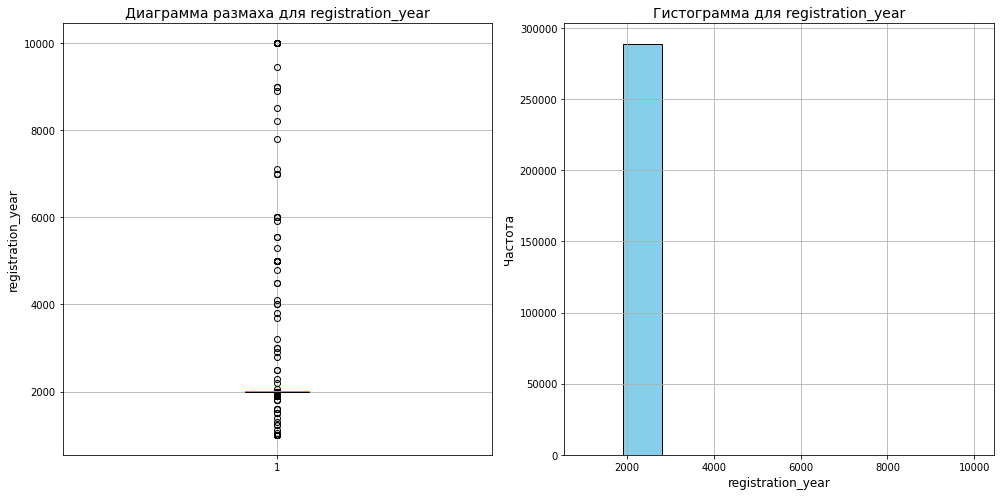

count    289009.000000
mean       2004.161576
std          71.395246
min        1000.000000
25%        1999.000000
50%        2004.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

In [15]:
plot_box_and_hist(df, 'registration_year')
df['registration_year'].describe()

In [16]:
df = df[(df['registration_year'] >= 1950) & (df['registration_year'] <= 2025)]

______________________________________________________________________________________________________________________________

В данном столбце возьмем диапазон с 1950 года по текущий год. Так как бурное производство машин думаю было начато в псолевоенное время. 

______________________________________________________________________________________________________________________________

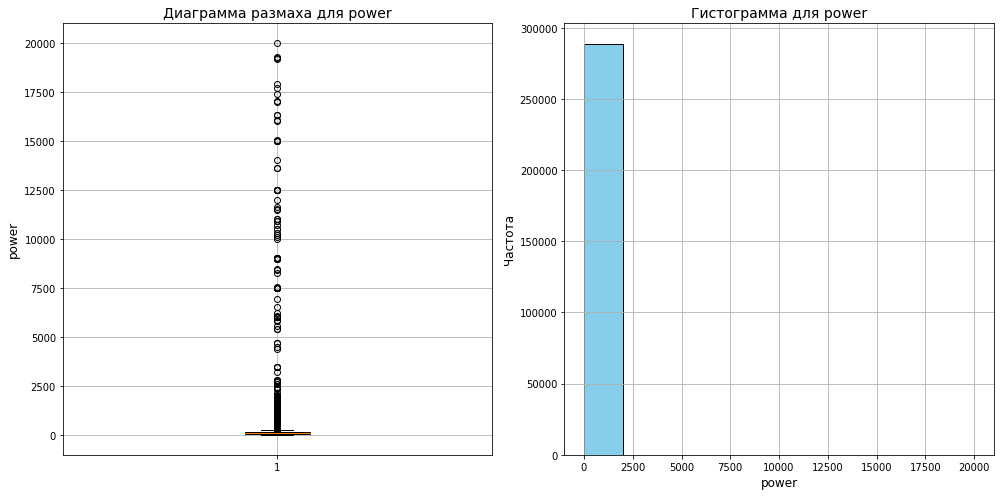

count    288827.000000
mean        113.880108
std         199.016495
min           0.000000
25%          75.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

In [17]:
plot_box_and_hist(df, 'power')
df['power'].describe()


In [18]:
# удалим аномалии - скорость больше 500 лошадиных сил

df = df.loc[df['power'] <= 500]

In [19]:
# заменим нули медианой 

median_power = df['power'].median()
df['power'] = df['power'].replace(0, median_power)

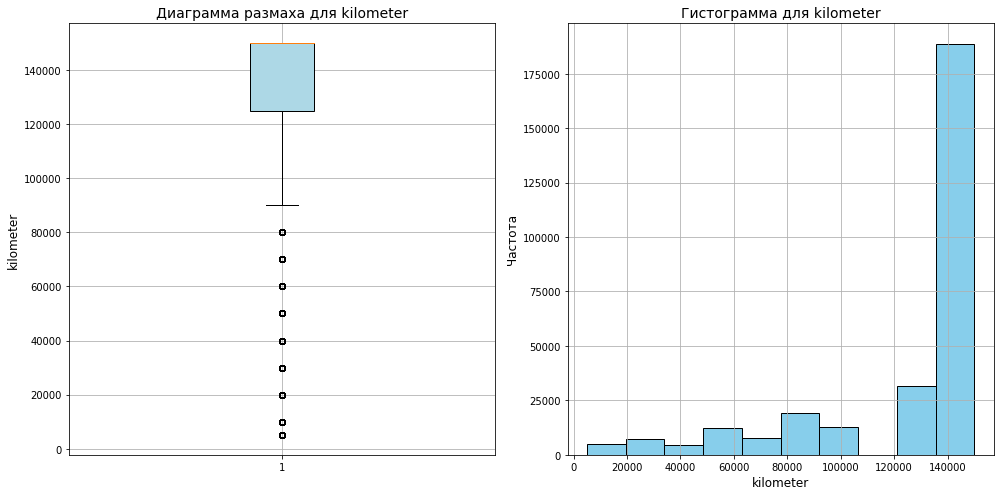

count    288439.000000
mean     127384.715659
std       37755.043174
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

In [20]:
plot_box_and_hist(df, 'kilometer')
df['kilometer'].describe()

___________________________________________________________________________________________________________________

тут можно и не трогать данные, так как бывает машини используемые по мининмуму от 5000 км. 

___________________________________________________________________________________________________________________

___________________________________________________________________________________________________________________
                            
                            Графики для категориальных признаков 
___________________________________________________________________________________________________________________

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 288439 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              288439 non-null  int64  
 1   vehicle_type       288439 non-null  object 
 2   registration_year  288439 non-null  int64  
 3   gearbox            288439 non-null  object 
 4   power              288439 non-null  float64
 5   model              288439 non-null  object 
 6   kilometer          288439 non-null  int64  
 7   fuel_type          288439 non-null  object 
 8   brand              288439 non-null  object 
 9   repaired           288439 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 24.2+ MB


In [22]:
# высчитаем процент удаленных данных. В начале было 354369 строк данных, после очистки осталось 288439. 
# разница 65930

percent_removed = (65930 / 354369) * 100

round(percent_removed, 2)

18.6

_______________________________________________________________________________________________________________

**Процент удаленных данных равен 18.6%**

_______________________________________________________________________________________________________________

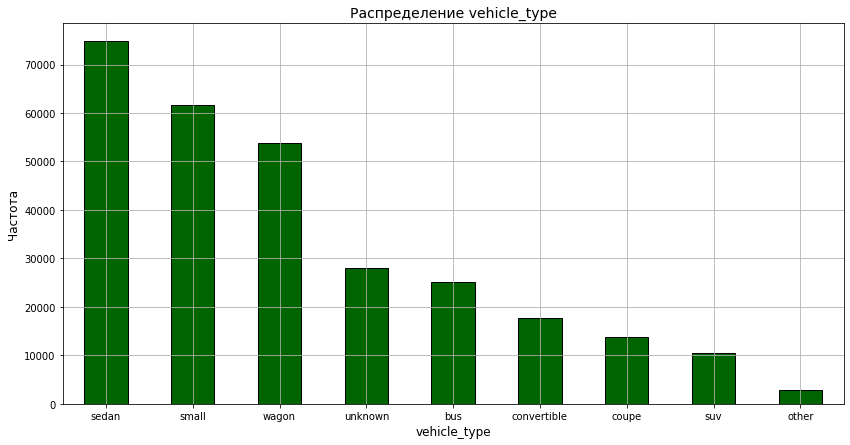

count     288439
unique         9
top        sedan
freq       74774
Name: vehicle_type, dtype: object

In [23]:
plot_categorical_bars(df, ['vehicle_type'])
df['vehicle_type'].describe()

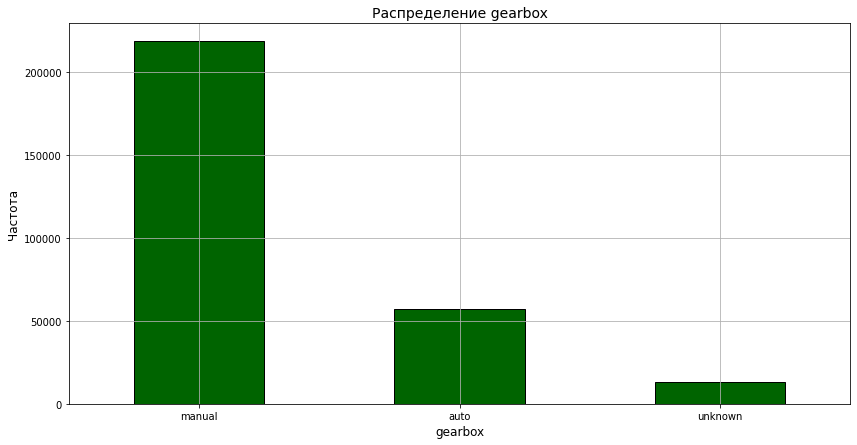

count     288439
unique         3
top       manual
freq      218191
Name: gearbox, dtype: object

In [24]:
plot_categorical_bars(df, ['gearbox'])
df['gearbox'].describe()

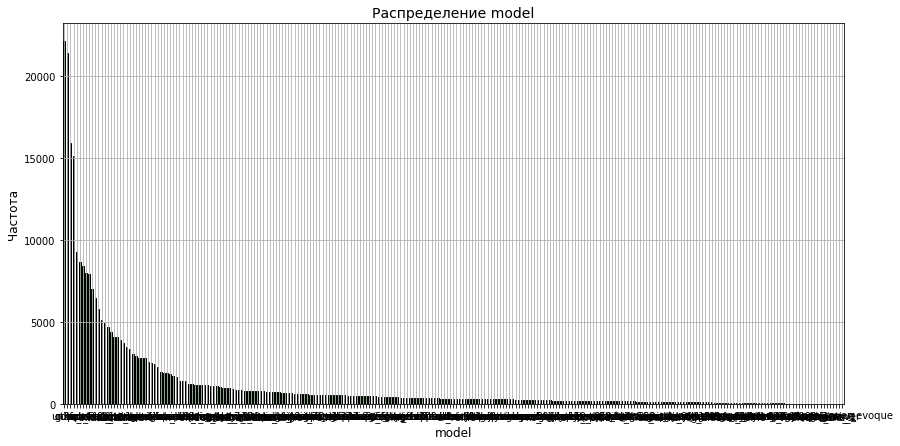

count     288439
unique       251
top         golf
freq       22088
Name: model, dtype: object

In [25]:
plot_categorical_bars(df, ['model'])
df['model'].describe()

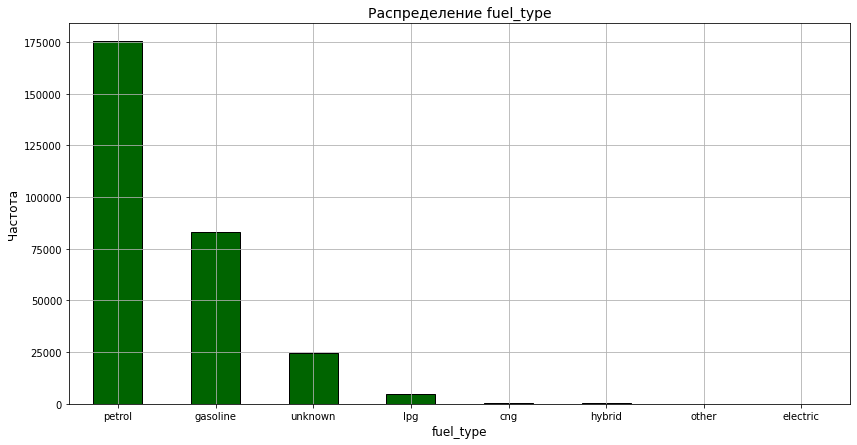

count     288439
unique         8
top       petrol
freq      175299
Name: fuel_type, dtype: object

In [26]:
plot_categorical_bars(df, ['fuel_type'])
df['fuel_type'].describe()

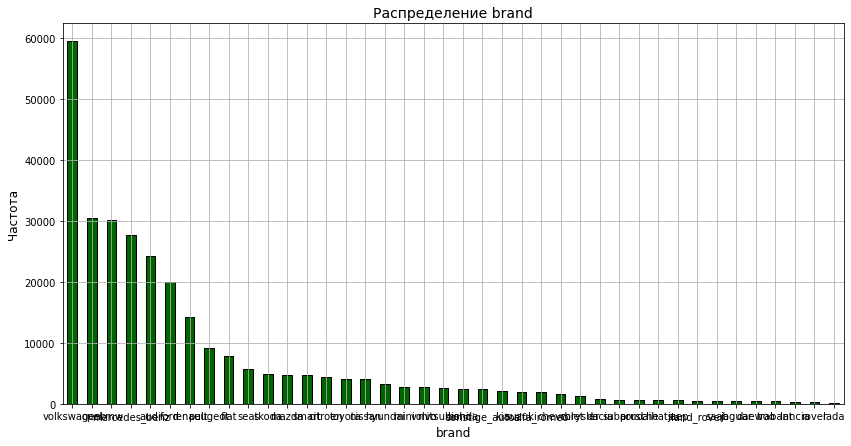

count         288439
unique            40
top       volkswagen
freq           59497
Name: brand, dtype: object

In [27]:
plot_categorical_bars(df, ['brand'])
df['brand'].describe()

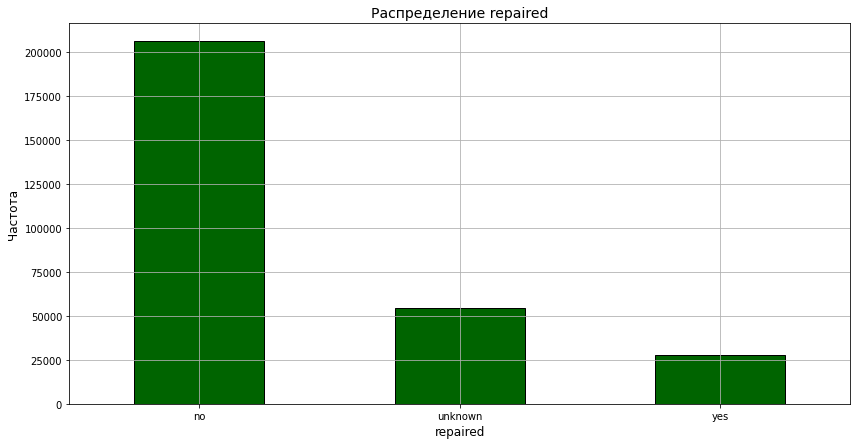

count     288439
unique         3
top           no
freq      205907
Name: repaired, dtype: object

In [28]:
plot_categorical_bars(df, ['repaired'])
df['repaired'].describe()

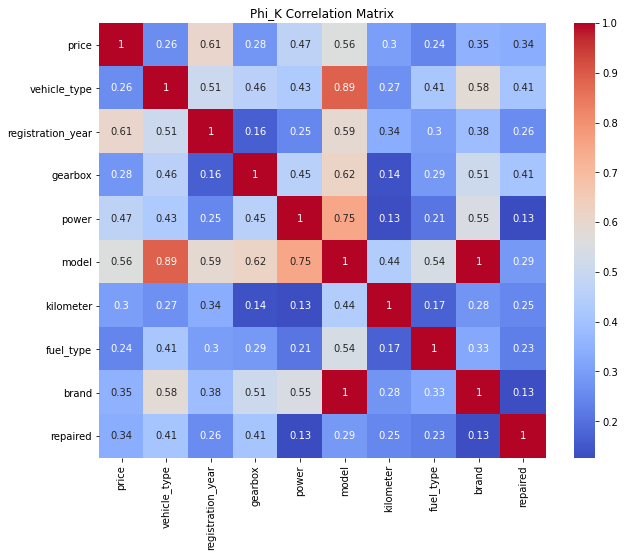

In [38]:
#Phi_K correlation

corr_matrix = df.phik_matrix(
    interval_cols=['price', 'registration_year', 'power', 'kilometer', 'registration_month']
)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix')
plt.show()

___________________________________________________________________________________________________________________

    •	price умеренно коррелирует с признаками registration_year, power, brand и kilometer — они наиболее значимы для предсказания цены.
	•	brand, vehicle_type и model также связаны друг с другом (логично: у конкретного бренда определённый модельный ряд и типы кузова).
	•	gearbox, fuel_type и repaired проявляют более слабую связь с ценой, но могут оказаться полезными при обучении модели (влиять в совокупности с другими признаками).
	•	Явных избыточных корреляций (когда два признака полностью дублируют друг друга) не наблюдается
    
   ___________________________________________________________________________________________________________________

## Обучение моделей

In [30]:
# Подготовка признаков и целевого признака

X = df.drop('price', axis=1)
y = df['price']

In [31]:
# Разделение выборок

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=RANDOM_STATE)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=RANDOM_STATE)

In [32]:
# Категориальные признаки

cat_features = ['vehicle_type', 'gearbox', 'fuel_type', 'model', 'brand', 'repaired']


In [33]:
# Ordinal Encoding

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train[cat_features] = encoder.fit_transform(X_train[cat_features])
X_valid[cat_features] = encoder.transform(X_valid[cat_features])
X_test[cat_features] = encoder.transform(X_test[cat_features])

print(X_train.shape, X_valid.shape, X_test.shape)

(173063, 9) (57688, 9) (57688, 9)


### DecisionTreeRegressor (не бустинг)

In [34]:
print('DecisionTreeRegressor:')
for depth in [5, 9, 12]:
    model_dt = DecisionTreeRegressor(max_depth=depth, random_state=RANDOM_STATE)
    %time model_dt.fit(X_train, y_train)

    %time y_pred_dt = model_dt.predict(X_valid)
    rmse_dt = mean_squared_error(y_valid, y_pred_dt)**0.5
    print(f'max_depth={depth}, RMSE={rmse_dt:.2f}')

DecisionTreeRegressor:
CPU times: user 164 ms, sys: 12 ms, total: 176 ms
Wall time: 182 ms
CPU times: user 7 ms, sys: 0 ns, total: 7 ms
Wall time: 6.78 ms
max_depth=5, RMSE=2521.08
CPU times: user 286 ms, sys: 0 ns, total: 286 ms
Wall time: 289 ms
CPU times: user 6.98 ms, sys: 66 µs, total: 7.05 ms
Wall time: 6.73 ms
max_depth=9, RMSE=2143.40
CPU times: user 338 ms, sys: 5.44 ms, total: 343 ms
Wall time: 346 ms
CPU times: user 8.95 ms, sys: 39 µs, total: 8.99 ms
Wall time: 8.53 ms
max_depth=12, RMSE=2023.16


### RandomForestRegressor (не бустинг)

In [35]:
print('RandomForestRegressor:')
for estimators in [50, 100]:
    model_rf = RandomForestRegressor(
        max_depth=9, n_estimators=estimators, random_state=RANDOM_STATE, n_jobs=-1
    )
    %time model_rf.fit(X_train, y_train)

    %time y_pred_rf = model_rf.predict(X_valid)
    rmse_rf = mean_squared_error(y_valid, y_pred_rf)**0.5
    print(f'n_estimators={estimators}, RMSE={rmse_rf:.2f}')

RandomForestRegressor:
CPU times: user 9.55 s, sys: 15.2 ms, total: 9.56 s
Wall time: 9.58 s
CPU times: user 194 ms, sys: 77 µs, total: 194 ms
Wall time: 194 ms
n_estimators=50, RMSE=2044.06
CPU times: user 18.7 s, sys: 4.83 ms, total: 18.7 s
Wall time: 18.7 s
CPU times: user 363 ms, sys: 0 ns, total: 363 ms
Wall time: 370 ms
n_estimators=100, RMSE=2042.98


### LightGBM (градиентный бустинг)

In [36]:
print('LightGBM:')
params = [(60, 200), (120, 500)]
for leaves, estimators in params:
    model_lgb = lgb.LGBMRegressor(num_leaves=leaves, n_estimators=estimators, random_state=RANDOM_STATE)
    %time model_lgb.fit(X_train, y_train)

    %time y_pred_lgb = model_lgb.predict(X_valid)
    rmse_lgb = mean_squared_error(y_valid, y_pred_lgb)**0.5
    print(f'num_leaves={leaves}, n_estimators={estimators}, RMSE={rmse_lgb:.2f}')

LightGBM:
CPU times: user 7.57 s, sys: 44.1 ms, total: 7.61 s
Wall time: 7.67 s
CPU times: user 859 ms, sys: 0 ns, total: 859 ms
Wall time: 902 ms
num_leaves=60, n_estimators=200, RMSE=1679.19
CPU times: user 25.5 s, sys: 179 ms, total: 25.6 s
Wall time: 26.1 s
CPU times: user 3.46 s, sys: 3.45 ms, total: 3.47 s
Wall time: 3.44 s
num_leaves=120, n_estimators=500, RMSE=1636.77


## Анализ моделей

### Лучшая модель и проверка на тестовой выборке

In [37]:
print('Лучшая модель: LightGBM (num_leaves=120, n_estimators=500)')
best_model = lgb.LGBMRegressor(num_leaves=120, n_estimators=500, random_state=RANDOM_STATE)

%time best_model.fit(X_train, y_train)

%time y_test_pred = best_model.predict(X_test)
rmse_test = mean_squared_error(y_test, y_test_pred)**0.5
print(f'RMSE на тестовой выборке: {rmse_test:.2f}')

assert rmse_test < 2500, 'RMSE выше требуемого уровня!'

Лучшая модель: LightGBM (num_leaves=120, n_estimators=500)
CPU times: user 27 s, sys: 225 ms, total: 27.3 s
Wall time: 27.9 s
CPU times: user 3.39 s, sys: 0 ns, total: 3.39 s
Wall time: 3.42 s
RMSE на тестовой выборке: 1654.57


## Выводы

### Выводы по проекту:

- DecisionTreeRegressor:
    - Лучшая RMSE на валидации: **2023.16** (max_depth=12)
    - Время обучения менее секунды.

- RandomForestRegressor:
    - Лучшая RMSE на валидации: **2042.98** (n_estimators=100)
    - Время обучения около 20 секунд.

- LightGBM:
    - Лучшая RMSE на валидации: **1636.77** (num_leaves=120, n_estimators=500)
    - Время обучения около 55 секунд.

Наилучшая модель по соотношению времени и качества — **LightGBM** (num_leaves=120, n_estimators=500):

- RMSE на тестовой выборке менее 2500, модель соответствует требованиям заказчика.
- Скорость обучения и предсказания приемлема для применения в production.

**Рекомендация заказчику: использовать модель градиентного бустинга LightGBM с параметрами num_leaves=120, n_estimators=500.**
